In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
data1 = pd.read_csv('/kaggle/input/data-lelang-dan-rencana-pengadaan-rup/DATATHON_XLS/lelang-id-2017-2018.csv', sep=';', encoding="ISO-8859-1")
data2 =  pd.read_csv('/kaggle/input/data-lelang-dan-rencana-pengadaan-rup/DATATHON_XLS/rup-id-2017-2018.csv', sep=';', encoding="ISO-8859-1")

In [ ]:
data1.drop_duplicates(inplace=True)

data2.drop_duplicates(inplace=True)

### Data secara umum

In [ ]:
data1.dtypes

In [ ]:
data1.nunique()

In [ ]:
data1.describe()

### Menghilangkan hasil lelang yang non numerik


In [ ]:
# cek hasil lelang yang non numerik
data1['hasil_lelang'].astype(str).value_counts()

In [ ]:
data1 = data1[~data1['hasil_lelang'].isin(['Barang/jasa', 'Modal', 'jenis_belanja', '-', 'Belum Teridentifikasi'])]

data1['hasil_lelang'] = data1['hasil_lelang'].astype(np.float32)

In [ ]:
data1['hasil_lelang'].head()

### menghilangkan kode rup yang non numerik atau bernilai nol

In [ ]:
# cek kode rup yang non numerik
data1['kode_rup'].astype(str).value_counts()

In [ ]:
data1 = data1.loc[~data1['kode_rup'].isin(['-', '0'])]

data1 = data1[~data1['kode_rup'].isnull()]

### Format hps menjadi float

In [ ]:
data1['hps'] = data1['hps'].astype(np.float32)

### Proporsi dari hasil lelang dibandingkan dengan hps

In [ ]:
data1['hps_lelang_prop'] = data1['hasil_lelang']/data1['hps']

data1['hps_lelang_prop'] = data1['hps_lelang_prop'].replace([np.inf, -np.inf], np.nan)

### Membuang outlier dan data tak wajar

In [ ]:
import seaborn as sns
# membuat boxplot
sns.boxplot(x=data1['hps_lelang_prop'])
# terlihat adanya outlier

In [ ]:
# menggunakan IQR untuk mendeteksi dan menghilangkan outlier
Q1 = data1['hps_lelang_prop'].quantile(0.25)
Q3 = data1['hps_lelang_prop'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
dummy = data1[~((data1['hps_lelang_prop'] < (Q1 - 1.5 * IQR)) |(data1['hps_lelang_prop'] > (Q3 + 1.5 * IQR)))]

In [ ]:
sns.boxplot(x=dummy['hps_lelang_prop'])
# terlihat bahwasanya outlier sudah tidak terlihat

In [ ]:
dummy = dummy[~dummy['hps_lelang_prop'].isnull()]

Menmbenarkan data tanggal kontrak

In [ ]:
dummy['tanggal_kontrak'] = dummy['tanggal_kontrak'].replace('-', np.NaN)
dummy['tanggal_kontrak'] = dummy['tanggal_kontrak'].replace('.', '')

dummy['tgl_akhir_kontrak'] = dummy['tgl_akhir_kontrak'].replace('-', np.NaN)
dummy['tgl_akhir_kontrak'] = dummy['tgl_akhir_kontrak'].str.replace('.', '')

dummy['tgl_akhir_kontrak'].replace('18-10-03 00:00:00', '2018-10-03 00:00:00', inplace=True)
dummy['tgl_akhir_kontrak'].replace('202018-10-03 00:00:000', '2018-10-03 00:00:00', inplace=True)
dummy['tgl_akhir_kontrak'].replace('002018-10-03 00:00:00', '2018-10-03 00:00:00',  inplace=True)
dummy['tgl_akhir_kontrak'].replace('202018-10-03 00:00:00', '2018-10-03 00:00:00',  inplace=True)
dummy['tgl_akhir_kontrak'].replace('18-12-10 00:00:00', '2018-12-10 00:00:00', inplace=True)

### Menghilangkan data yang tidak relevan pada kolom sumber dana

In [ ]:
dummy['sumber_dana'].astype(str).value_counts().sort_index()

In [ ]:
dummy = dummy[~dummy['sumber_dana'].isin(['-', '1', '2', '8', '9'])]

### Penentuan terindikasi korupsi 
Menurut ICW, suatu lelang yang terindikasi korupsi adalah yang nilai HPS-nya terlalu dekat dengan harga lelang. Untuk menentukan seberapa dekat kami memilih kuartil 25.

In [ ]:
((1-dummy['hps_lelang_prop'])).describe()

In [ ]:
dummy.loc[((1-dummy['hps_lelang_prop'])) < 0.01, 'indikasi_korup'] = 1

In [ ]:
dummy['indikasi_korup'].fillna(0, inplace=True)

### Menentukan variabel independen yang akan dieksplorasi
Tujuan utama dari analisis ini adalah membantu pemerintah untuk mencegah praktik korupsi di pengadaan. Indikasi yang biasanya dipakai adalah HPS, hasil lelang, Jumlah peserta, dan Jumlah penawar. Hanya saja untuk mendapatkan indikator tersebut, lelang harus sudah selesai terlebih dahulu. Alhasil langkah yang dapat dilakukan hanya corrective saja bukan preventive. Pada analisis kali ini variabel independen yang akan dianalisis merupakan variabel yang sudah bisa didapatkan saat lelang masih dalam tahap perencanaan. Sedangkan variabel dependen kali ini adalah indikasi korupsi

Gambar di bawah ini dan dokumen dari [PUPR ini ](https://www.pu.go.id/assets/images/pdf/Ntc_101228173012.pdf)dapat memberikan gambaran variabel apa saja yang bisa didapatkan.

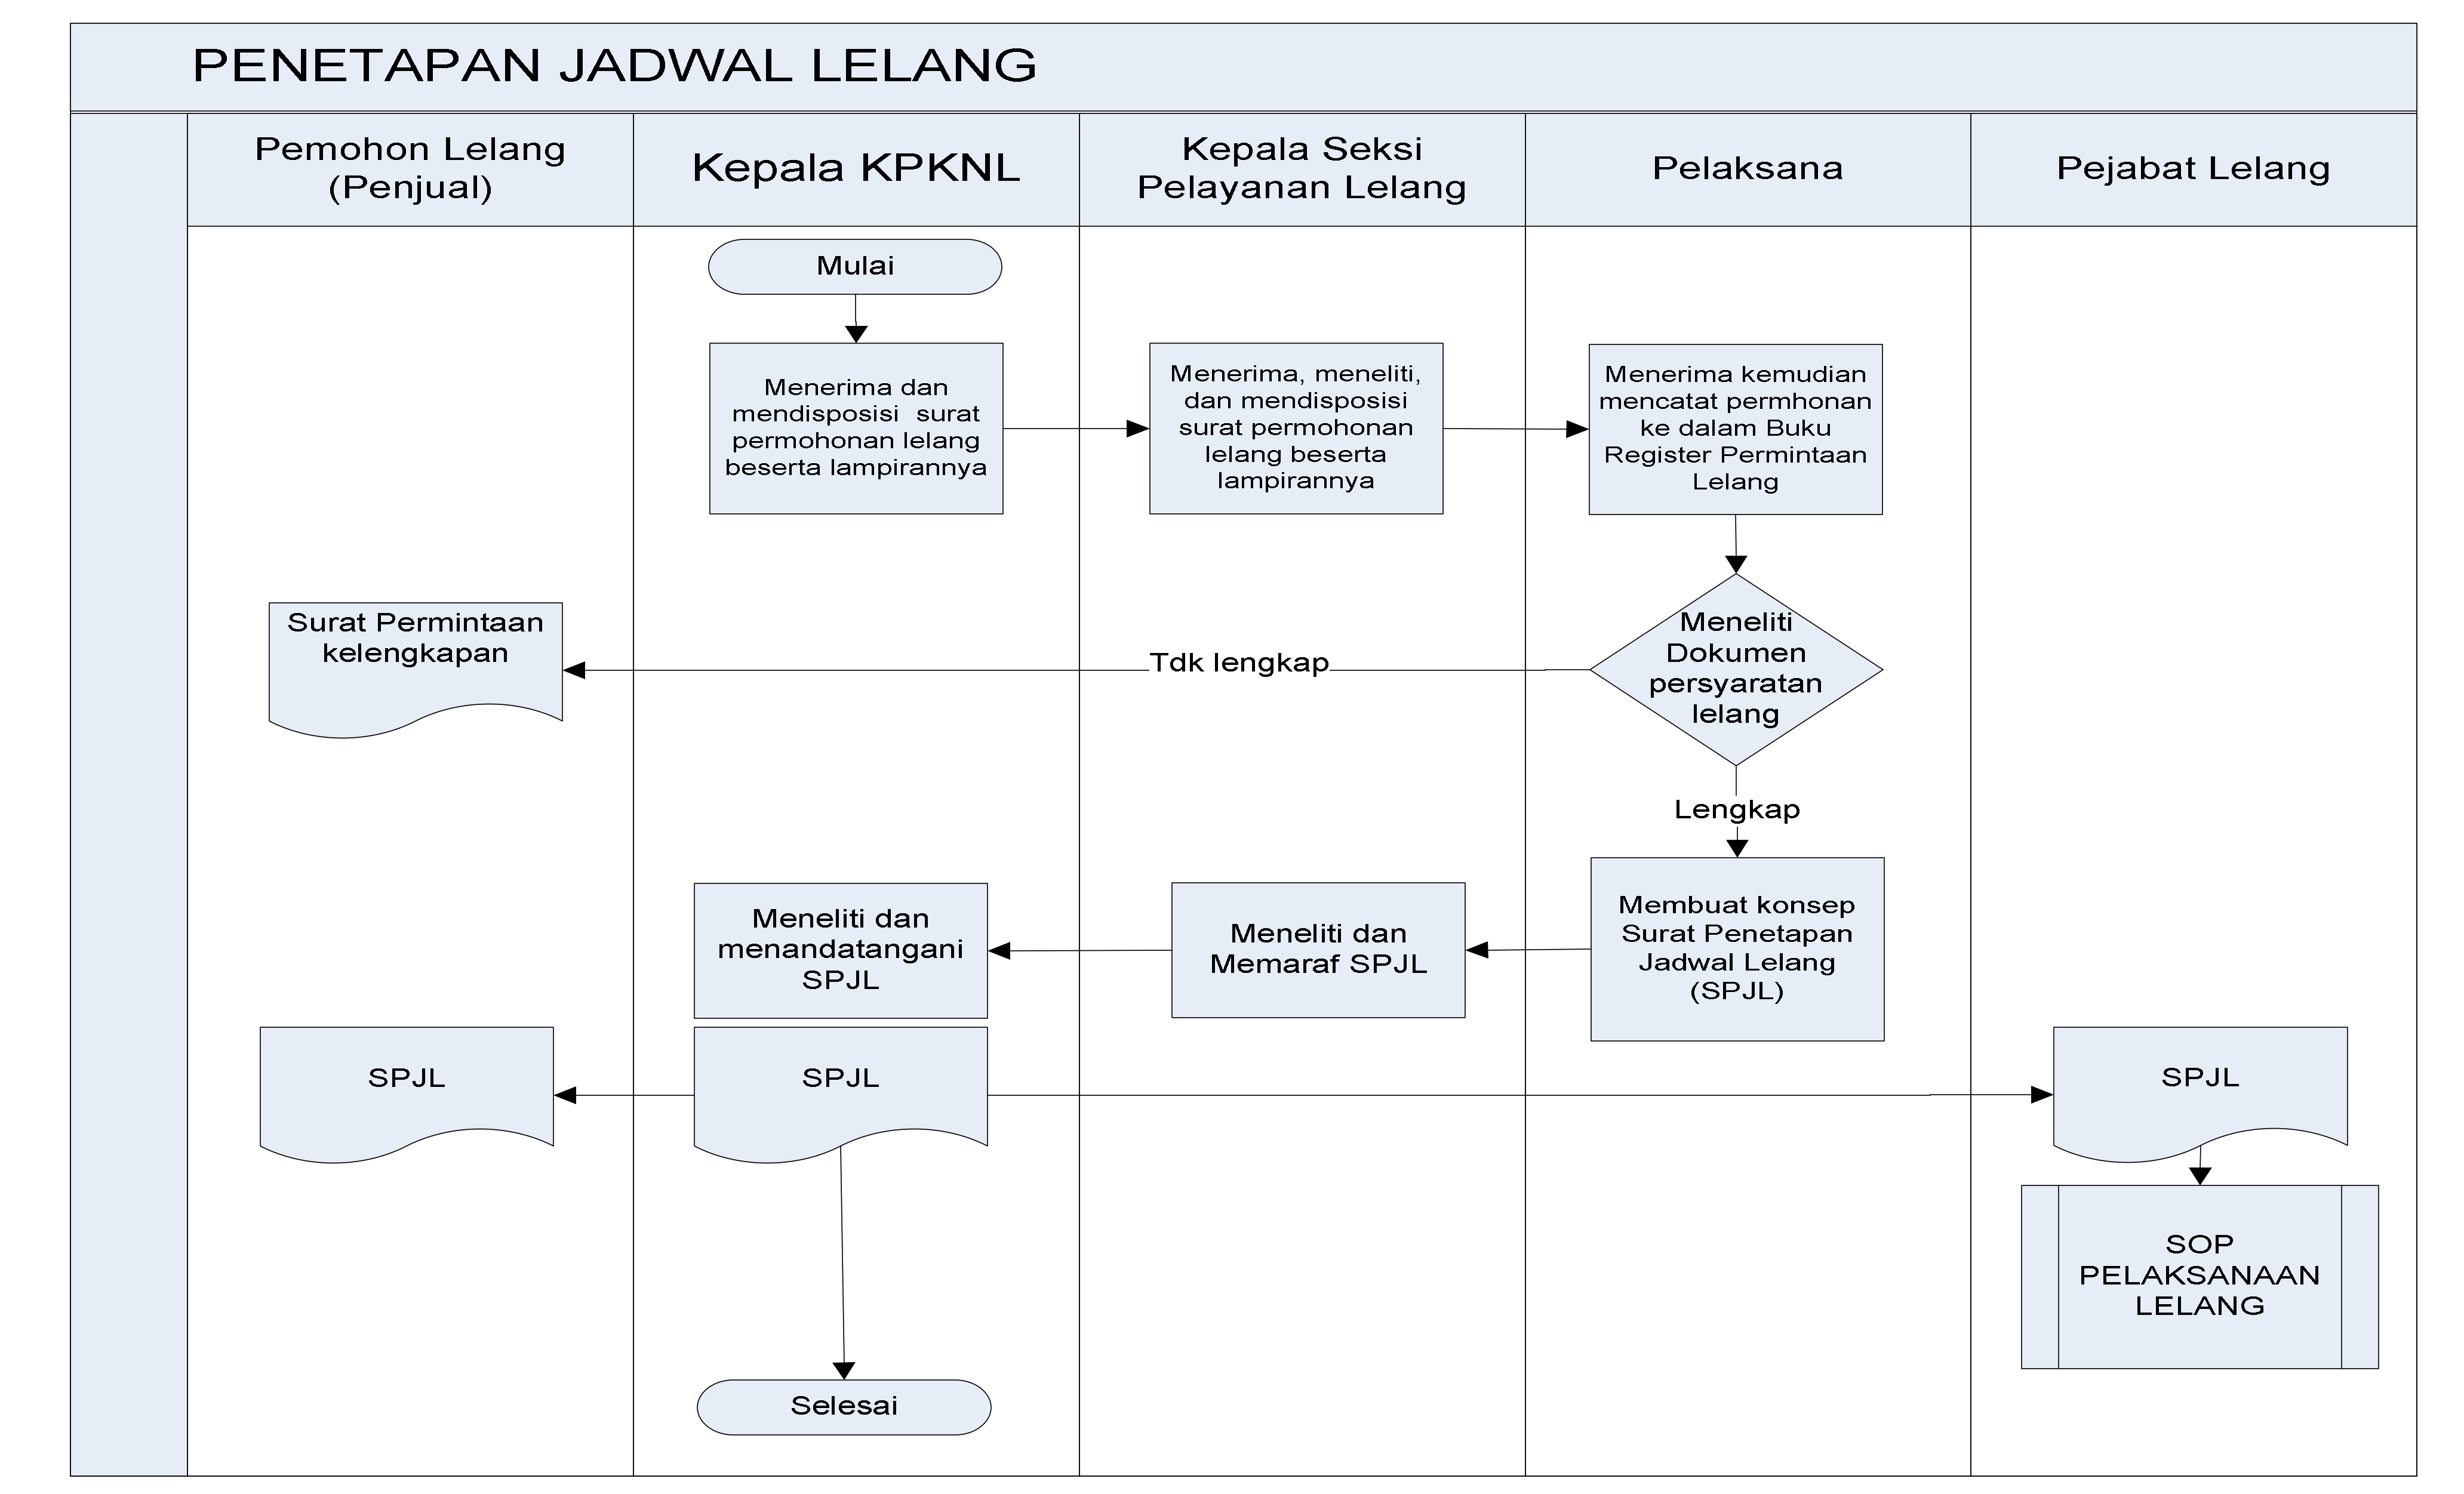

### Berdasarkan sumber dana

In [ ]:
dummy

In [ ]:
#jumlah korupsi berdasarkan sumber dana
cnt = dummy.groupby('sumber_dana')['indikasi_korup'].sum()
n = dummy.groupby('sumber_dana')['indikasi_korup'].count()
(cnt/n)[cnt>1].sort_values(ascending=False).plot(kind='bar')

In [ ]:
cnt.sort_values(ascending=False).plot(kind='bar')

### kategori_lelang

In [ ]:
dummy.columns

In [ ]:
(dummy.groupby(['kategori_lelang'])['indikasi_korup'].sum()/dummy['kategori_lelang'].value_counts()).sort_values(ascending=False).plot(kind='bar')

### Berdasarkan lama kontrak

In [ ]:
dummy['tgl_akhir_kontrak'] = pd.to_datetime(dummy['tgl_akhir_kontrak'], errors = 'coerce')
dummy['tanggal_kontrak'] = pd.to_datetime(dummy['tanggal_kontrak'], errors = 'coerce')
dummy['tanggal_kontrak'] = dummy['tanggal_kontrak'].replace('0108-02-22 00:00:00.0', '2018-02-22 00:00:00.0')


In [ ]:
dummy['periode_kontrak'] = dummy['tgl_akhir_kontrak']- dummy['tanggal_kontrak']
dummy['periode_kontrak'] = dummy['periode_kontrak'].map(lambda x: np.nan if pd.isnull(x) else x.days)


In [ ]:
from scipy.stats import pointbiserialr

pointbiserialr(dummy.loc[~dummy['periode_kontrak'].isnull(), 'periode_kontrak'], dummy.loc[~dummy['periode_kontrak'].isnull(), 'indikasi_korup'])

In [ ]:
pointbiserialr(dummy.loc[~dummy['pagu'].isnull(), 'pagu'], dummy.loc[~dummy['pagu'].isnull(), 'indikasi_korup'])

In [ ]:
from scipy.stats import pointbiserialr

pointbiserialr(dummy.loc[~dummy['hps'].isnull()  , 'hps'], dummy.loc[~dummy['hps'].isnull(), 'indikasi_korup'])

 lama kontrak dan indikasi korupsi memiliki korelasi negatif

### Berdasarkan Provinsi

In [ ]:
((dummy.groupby(['nama_propinsi'])['indikasi_korup'].sum()/dummy.groupby(['nama_propinsi'])['nama_propinsi'].count()).sort_values(ascending=False)).plot(kind='bar')

In [ ]:
dummy['nama_paket'].value_counts()

In [ ]:
col_X = ['hps', 'periode_kontrak', 'pagu', 'kategori_lelang']

In [ ]:
dummy['pagu'] = dummy['pagu'].astype(np.float32)

In [ ]:
dummy['kategori_lelang'].astype(str).value_counts()

In [ ]:
my = dummy[col_X].dropna().index

Modeling


In [ ]:
from sklearn.linear_model import LogisticRegression

X = dummy.loc[my, col_X]
y = dummy.loc[my, 'indikasi_korup']

X.iloc[:,[0,1,2]] = (X.iloc[:,[0,1,2]] - X.iloc[:,[0,1,2]].min())/(X.iloc[:,[0,1,2]].max()-X.iloc[:,[0,1,2]].min())

X = pd.get_dummies(X)
m = LogisticRegression()

m.fit(X,y)

print(m.coef_)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}

m = RandomForestClassifier(**params)

m.fit(X,y)


In [ ]:
m.feature_importances_

In [ ]:
X.columns[np.argsort(-1 * m.feature_importances_)]

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

def cv(X,y):
    
    params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
#     gb_params = { 'n_estimators': 1000, 
#                   'eta': 0.01, 
#                   'random_state': 0, 
#                   'max_depth' : 5,
#                   'subsample': 0.5, 
#                   'colsample_bytree': 0.7,
#                   }
#     xgb = XGBClassifier(**gb_params)
    rf = RandomForestClassifier(**params)


    kf = StratifiedKFold(n_splits=5)
    m = LogisticRegression()


    rf_score = cross_val_score(rf, X, y, cv=kf, scoring='roc_auc' ,n_jobs=-1)
    
    print(rf_score)
    
    print(rf_score.sum()/5)


In [ ]:
cv(X,y)

    Extreme Comparison

In [ ]:
((dummy.loc[dummy['nama_propinsi'].isin(['Lampung','Sulawesi Tenggara','Sulawesi Barat','Jawa Barat','Banten','Papua Barat'])].groupby(['nama_propinsi'])['indikasi_korup'].sum()/dummy.loc[dummy['nama_propinsi'].isin(['Lampung','Sulawesi Tenggara','Sulawesi Barat','Jawa Barat','Banten','Papua Barat'])].groupby(['nama_propinsi'])['nama_propinsi'].count()).sort_values(ascending=False)).plot(kind='bar')

provinsi lampung, sulawesi tenggara, sulawesi barat diambil sebagai provinsi dengan tingkat korupsi terduga yang tinggi dan dibandingkan dengan provinsi jawa barat, banten, dan papua barat sebagai provinsi degan tingkat korupsi terduga rendah.

In [ ]:
((dummy.loc[dummy['nama_propinsi'].isin(['Lampung','Sulawesi Tenggara','Sulawesi Barat','Jawa Barat','Banten','Papua Barat'])].groupby(['nama_propinsi'])['pagu'].mean()).sort_values(ascending=False)).plot(kind='bar')

In [ ]:
((dummy.loc[dummy['nama_propinsi'].isin(['Lampung','Sulawesi Tenggara','Sulawesi Barat','Jawa Barat','Banten','Papua Barat'])].groupby(['nama_propinsi'])['hps'].mean()).sort_values(ascending=False)).plot(kind='bar')